In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pylab import rcParams

In [2]:
NVDA_prices = pd.read_csv('NVDA.csv', sep=',').fillna(0)

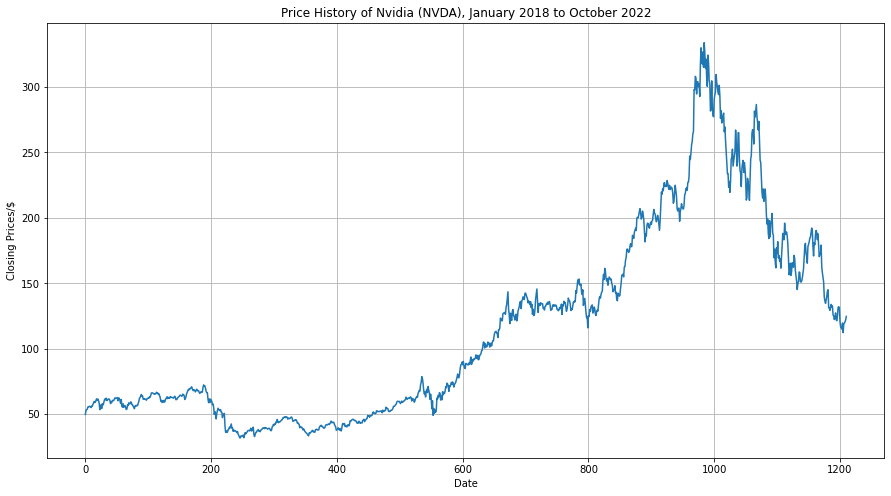

In [3]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Prices/$')
plt.plot(NVDA_prices['Close'])
plt.title('Price History of Nvidia (NVDA), January 2018 to October 2022')
plt.show()

In [4]:
df_close = NVDA_prices[['Date', 'Close']]

In [5]:
df_close

,Date,Close
0,2/1/2018,49.837502
1,3/1/2018,53.117500
2,4/1/2018,53.397499
3,5/1/2018,53.849998
4,8/1/2018,55.500000
...,...,...
1206,17/10/2022,118.879997
1207,18/10/2022,119.669998
1208,19/10/2022,120.510002
1209,20/10/2022,121.940002


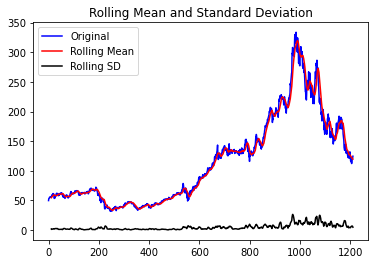

Results of ADF test
Test Statistics                  -1.227078
p-value                           0.661840
No. of lags used                 15.000000
Number of observations used    1195.000000
critical value (1%)              -3.435834
critical value (5%)              -2.863962
critical value (10%)             -2.568059
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling SD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of ADF test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close['Close'])

<Figure size 432x288 with 0 Axes>

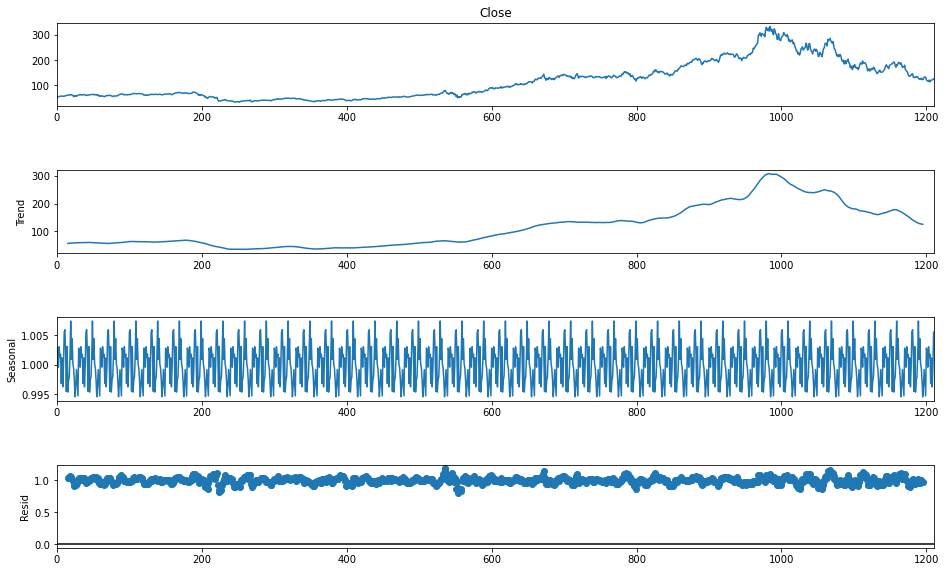

In [7]:
result = seasonal_decompose(df_close['Close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 9)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

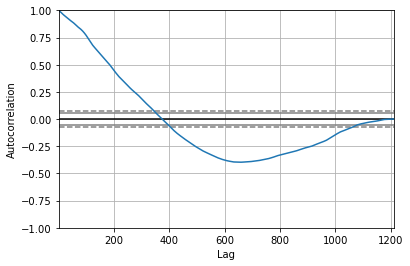

In [8]:
pd.plotting.autocorrelation_plot(df_close["Close"])

C:\Users\chuak\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


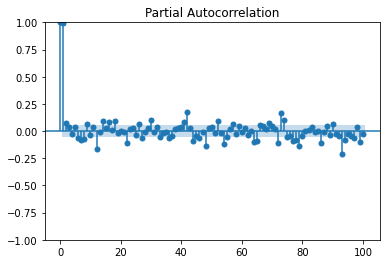

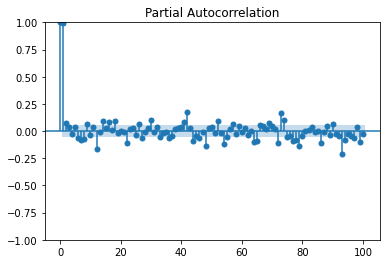

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_close["Close"], lags = 100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7165.781, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7164.977, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7164.824, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7163.993, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7166.495, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.003 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1211
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3580.997
Date:                Sat, 22 Oct 2022   AIC                           7163.993
Time:                        23:42:38   BIC                           7169.092
Sample:                             0   HQIC                          7165.913
                               - 1211                                       

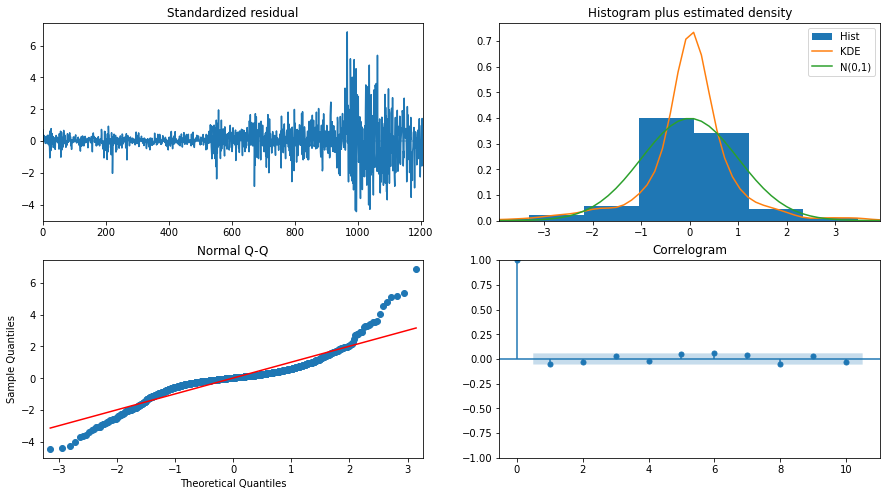

In [10]:
# autoARIMA to find the optimal p, d and q parameters for the ARIMA model:

model_autoARIMA = auto_arima(df_close['Close'], start_p=0, start_q=0,
                      test='adf',       # adftest finds optimal d
                      max_p=3, max_q=3,
                      m=1,              # frequency of series
                      d=None,           # let model determine parameter d
                      seasonal=False,  
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
# model building, using p = 0, d = 1 and q = 0
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(df_close['Close'], order=(0, 1, 0))  # p, d, q format
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1211
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3580.997
Date:                Sat, 22 Oct 2022   AIC                           7163.993
Time:                        23:43:07   BIC                           7169.092
Sample:                             0   HQIC                          7165.913
                               - 1211                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        21.7829      0.421     51.693      0.000      20.957      22.609
Ljung-Box (L1) (Q):                   2.81   Jarque-Bera (JB):              2367.89
Prob(Q):                              0.09   Pr

In [13]:
fitted.predict()
# need to re transform the values

0         0.000000
1        49.837502
2        53.117500
3        53.397499
4        53.849998
           ...    
1206    112.269997
1207    118.879997
1208    119.669998
1209    120.510002
1210    121.940002
Name: predicted_mean, Length: 1211, dtype: float64

In [ ]:
# choice of p, d, q parameters:
# The parameters selected were p = 0, d = 1 and q = 0. This was also found to have had the lowest AIC of the possible p, d, q 
# permutations, hence suggesting that the model with parameters p = 0, d = 1 and q = 0 was the most appropriate to use for the
# stock price prediction. ARIMA(0,1,0) suggests a random walk, where it is found that the stock's price series is not stationary
# The random walk only includes a nonseasonal difference term, hence the autoregressive coefficient is equal to 1, which is 
# appropriate for a series with infinitely slow mean reversion. There is no constant term, hence the formal term for this random
# walk model is a "random-walk-without-drift".

In [18]:
# SARIMA to account for seasonal data:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(df_close['Close'],
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 60))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1211
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 60)   Log Likelihood               -3829.602
Date:                            Sat, 22 Oct 2022   AIC                           7661.203
Time:                                    23:44:16   BIC                           7666.251
Sample:                                         0   HQIC                          7663.109
                                           - 1211                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        45.7122      1.037     44.063      0.000      43.679      47.746
Ljung-Box (L1) (Q):                

In [33]:
df_future =  pd.DataFrame(columns=['Date', 'Forecast'])

In [20]:
# prediction for the next 10 trading days:
predictions = model.predict(len(df_close['Close']), len(df_close['Close'])+9)
print(predictions)

1211    126.450013
1212    129.230012
1213    130.080003
1214    133.750001
1215    136.970002
1216    134.710007
1217    122.750001
1218    115.680009
1219    125.790009
1220    124.240006
Name: predicted_mean, dtype: float64


In [34]:
df_future['Date'] = pd.date_range(start= '2022-10-24', end = '2022-11-2')

In [35]:
# note: the dates in the dataframe are wrong
df_future['Forecast'] = np.array(predictions)
df_future

,Date,Forecast
0,2022-10-24,126.450013
1,2022-10-25,129.230012
2,2022-10-26,130.080003
3,2022-10-27,133.750001
4,2022-10-28,136.970002
5,2022-10-29,134.710007
6,2022-10-30,122.750001
7,2022-10-31,115.680009
8,2022-11-01,125.790009
9,2022-11-02,124.240006


In [36]:
df_future.to_csv("Koby_Chua_Yi_Wei_Impl_2.csv", index=False)